## Dependencies

In [1]:
import json, warnings, shutil
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from scripts_step_lr_schedulers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
# Unzip files
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean-label/fold_1.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean-label/fold_2.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean-label/fold_3.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean-label/fold_4.tar.gz
!tar -xf /kaggle/input/tweet-dataset-5fold-roberta-64-clean-label/fold_5.tar.gz

In [3]:
database_base_path = '/kaggle/input/tweet-dataset-5fold-roberta-64-clean-label/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
print(f'Training set samples: {len(k_fold)}')
display(k_fold.head())

Training set samples: 26882


,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,validation,train,train,train,False
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train,False
2,088c60f138,my boss is bullying me...,bullying,negative,0.200000,25,5,6,8,1,1,train,train,train,validation,train,False
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,train,train,validation,train,False
4,358bd9e861,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,train,validation,train,False


# Model parameters

In [4]:
vocab_path = database_base_path + 'vocab.json'
merges_path = database_base_path + 'merges.txt'
base_path = '/kaggle/input/qa-transformers/roberta/'

config = {
  'MAX_LEN': 64,
  'BATCH_SIZE': 32,
  'EPOCHS': 7,
  'LEARNING_RATE': 3e-5,
  'ES_PATIENCE': 2,
  'N_FOLDS': 5,
  'question_size': 4,
  'base_model_path': base_path + 'roberta-base-tf_model.h5',
  'config_path': base_path + 'roberta-base-config.json'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [5]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)
tokenizer.save('./')

['./vocab.json', './merges.txt']

## Learning rate schedule

Learning rate schedule: 1e-07 to 2.96e-05 to 1e-06


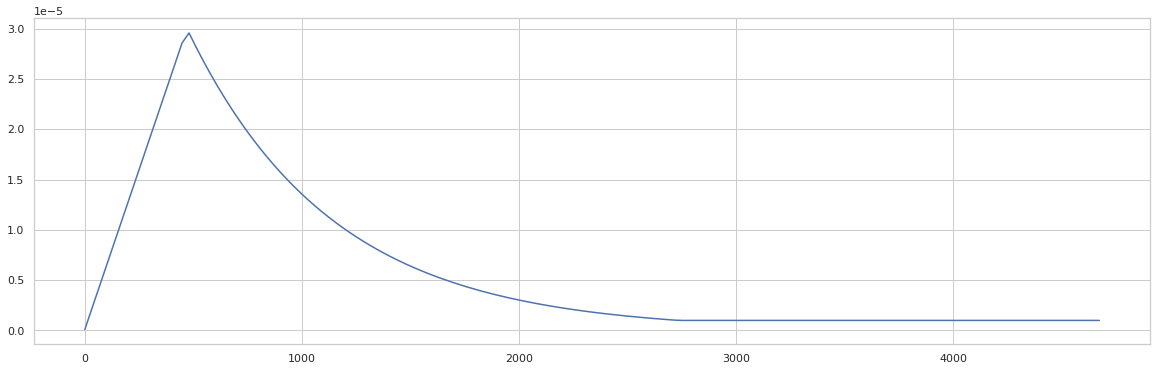

In [6]:
lr_min = 1e-6
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
warmup_steps = total_steps * 0.1
decay = .9985

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=warmup_steps, lr_start=lr_start, 
                                      lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [7]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=True)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    _, _, hidden_states = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    h11 = hidden_states[-2]

    x = layers.Dropout(.1)(h11)
    
    mask_logits = layers.Dense(1, name="mask_logit", use_bias=False)(x)
    mask_logits = layers.Flatten()(mask_logits)
    
    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(x)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(x)
    end_logits = layers.Flatten()(end_logits)
    

    start_probs = layers.Activation('softmax', name='y_start')(start_logits)
    end_probs = layers.Activation('softmax', name='y_end')(end_logits)
    mask_probs = layers.Activation('sigmoid', name='y_mask')(mask_logits)

    model = Model(inputs=[input_ids, attention_mask], outputs=[start_probs, end_probs, mask_probs])
    
    return model

# Train

In [8]:
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 'attention_mask': x_train[1]}, 
                                                  {'y_start': y_train[0], 'y_end': y_train[1], 'y_mask': y_train[2]}))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 'attention_mask': x_valid[1]}, 
                                                  {'y_start': y_valid[0], 'y_end': y_valid[1], 'y_mask': y_valid[2]}))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

In [9]:
AUTO = tf.data.experimental.AUTOTUNE
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))
    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    y_train_mask = np.load(base_data_path + 'y_train_mask.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    y_valid_mask = np.load(base_data_path + 'y_valid_mask.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint(model_path, monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=warmup_steps, lr_start=lr_start, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(label_smoothing=0.2),
                                   'y_end': losses.CategoricalCrossentropy(label_smoothing=0.2),
                                   'y_mask': losses.BinaryCrossentropy(label_smoothing=0.2)})
    
    history = model.fit(get_training_dataset(x_train, (*y_train, y_train_mask), config['BATCH_SIZE'], AUTO, seed=SEED),
                        validation_data=(get_validation_dataset(x_valid, (*y_valid, y_valid_mask), config['BATCH_SIZE'], AUTO, repeated=False, seed=SEED)),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)

    # Make predictions
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])
    
    ### Delete data dir
    shutil.rmtree(base_data_path)


FOLD: 1
Train for 672 steps, validate for 168 steps
Epoch 1/7
672/672 - 178s - loss: 5.0014 - y_start_loss: 2.2594 - y_end_loss: 2.2932 - y_mask_loss: 0.4488 - val_loss: 3.9212 - val_y_start_loss: 1.7844 - val_y_end_loss: 1.7661 - val_y_mask_loss: 0.3706
Epoch 2/7
672/672 - 163s - loss: 4.0382 - y_start_loss: 1.8374 - y_end_loss: 1.8263 - y_mask_loss: 0.3745 - val_loss: 3.8814 - val_y_start_loss: 1.7743 - val_y_end_loss: 1.7410 - val_y_mask_loss: 0.3661
Epoch 3/7
672/672 - 163s - loss: 3.9437 - y_start_loss: 1.7967 - y_end_loss: 1.7755 - y_mask_loss: 0.3715 - val_loss: 3.8747 - val_y_start_loss: 1.7702 - val_y_end_loss: 1.7395 - val_y_mask_loss: 0.3649
Epoch 4/7
672/672 - 163s - loss: 3.9011 - y_start_loss: 1.7757 - y_end_loss: 1.7552 - y_mask_loss: 0.3702 - val_loss: 3.8708 - val_y_start_loss: 1.7671 - val_y_end_loss: 1.7388 - val_y_mask_loss: 0.3649
Epoch 5/7
672/672 - 161s - loss: 3.8865 - y_start_loss: 1.7683 - y_end_loss: 1.7485 - y_mask_loss: 0.3698 - val_loss: 3.8735 - val_y_st

# Model loss graph

Fold: 1


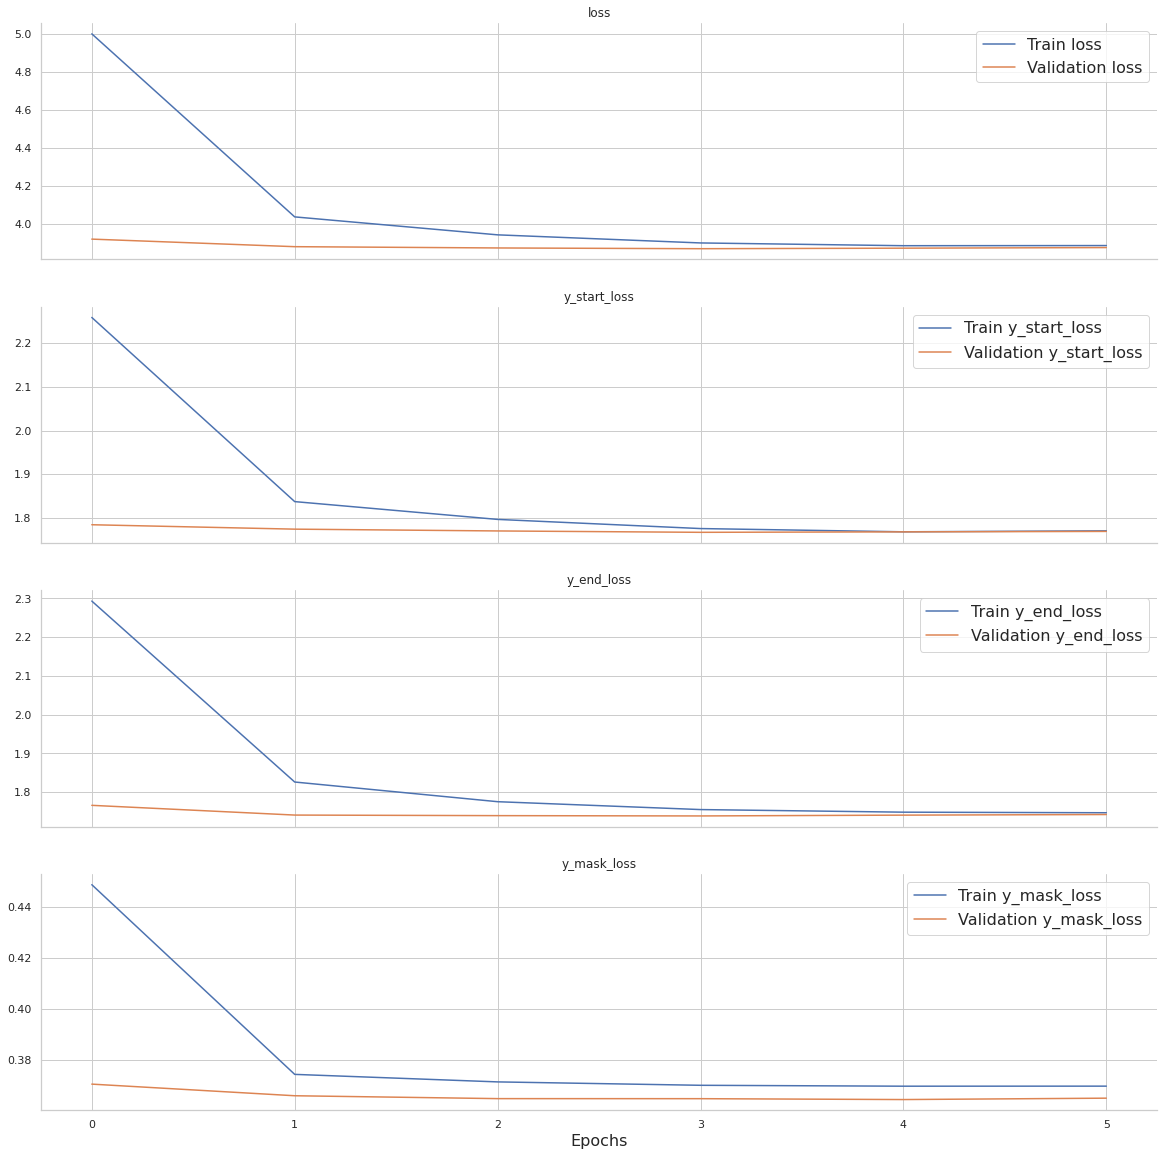

Fold: 2


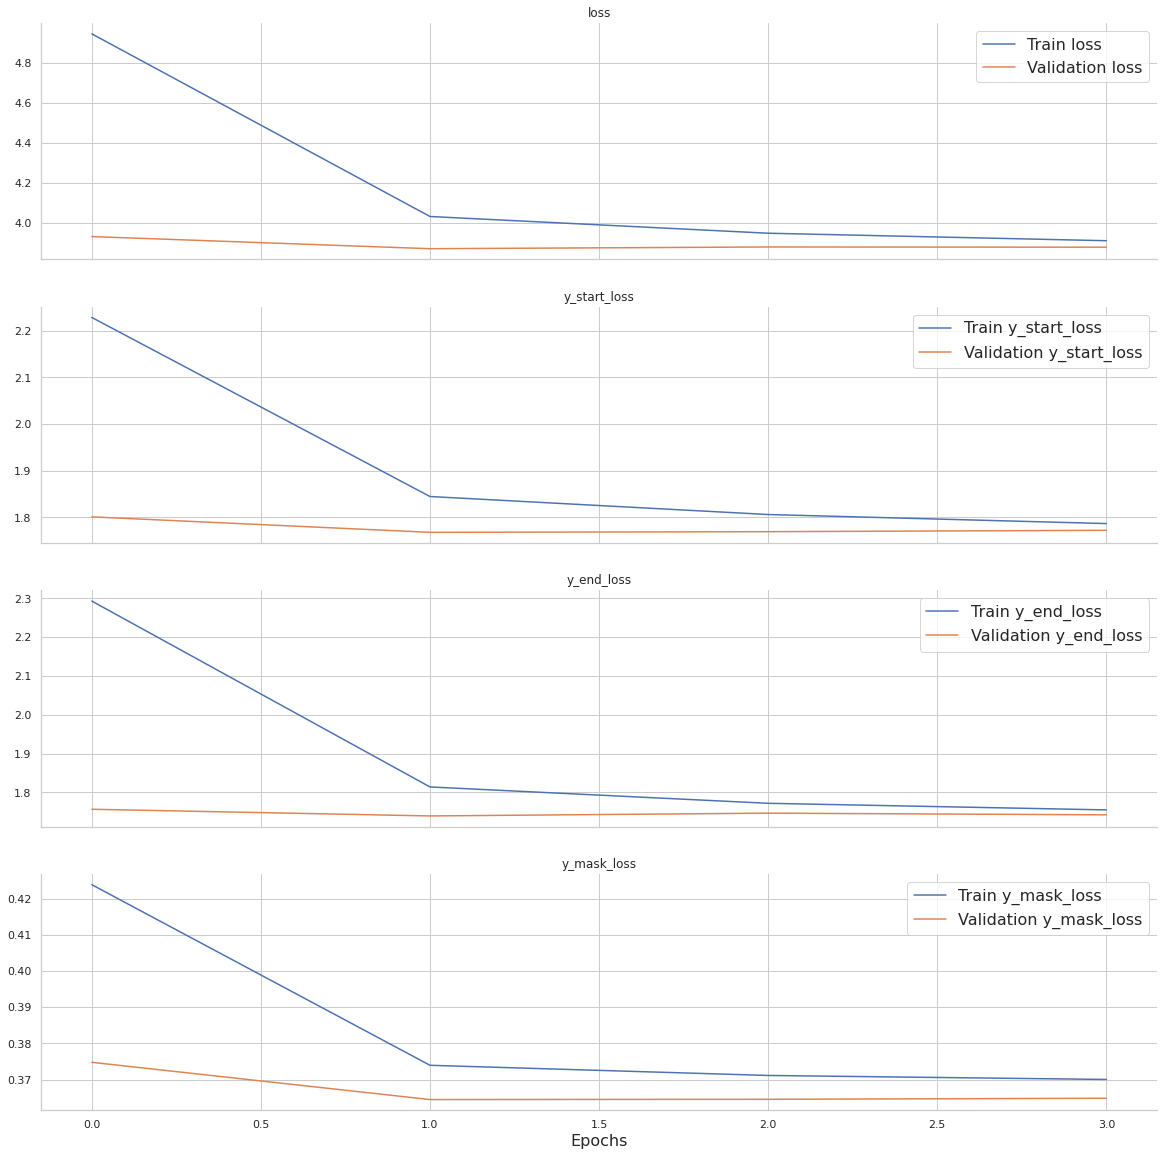

Fold: 3


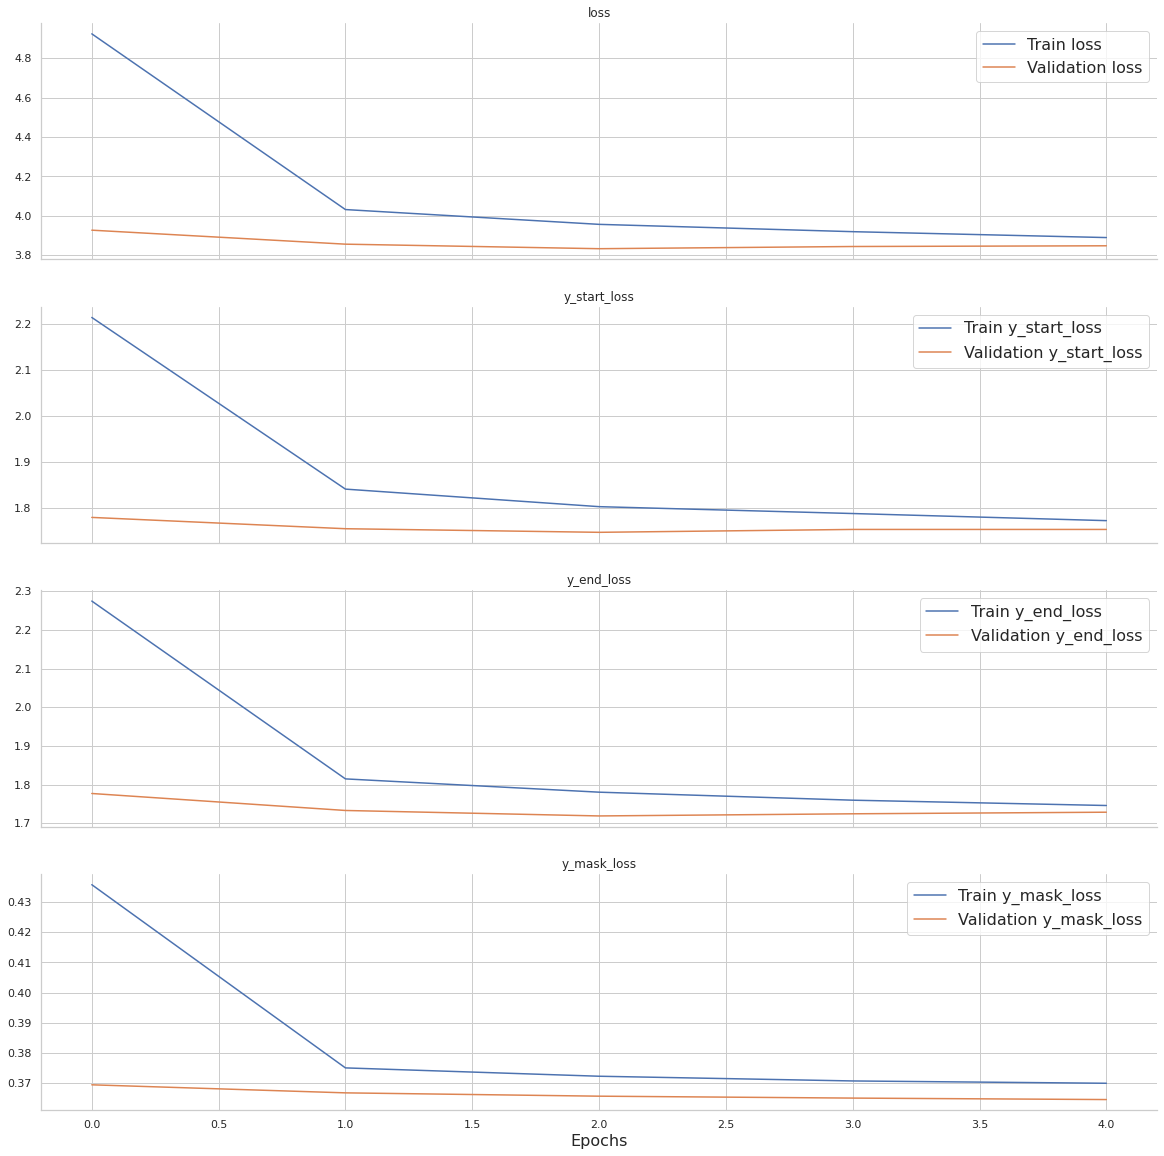

Fold: 4


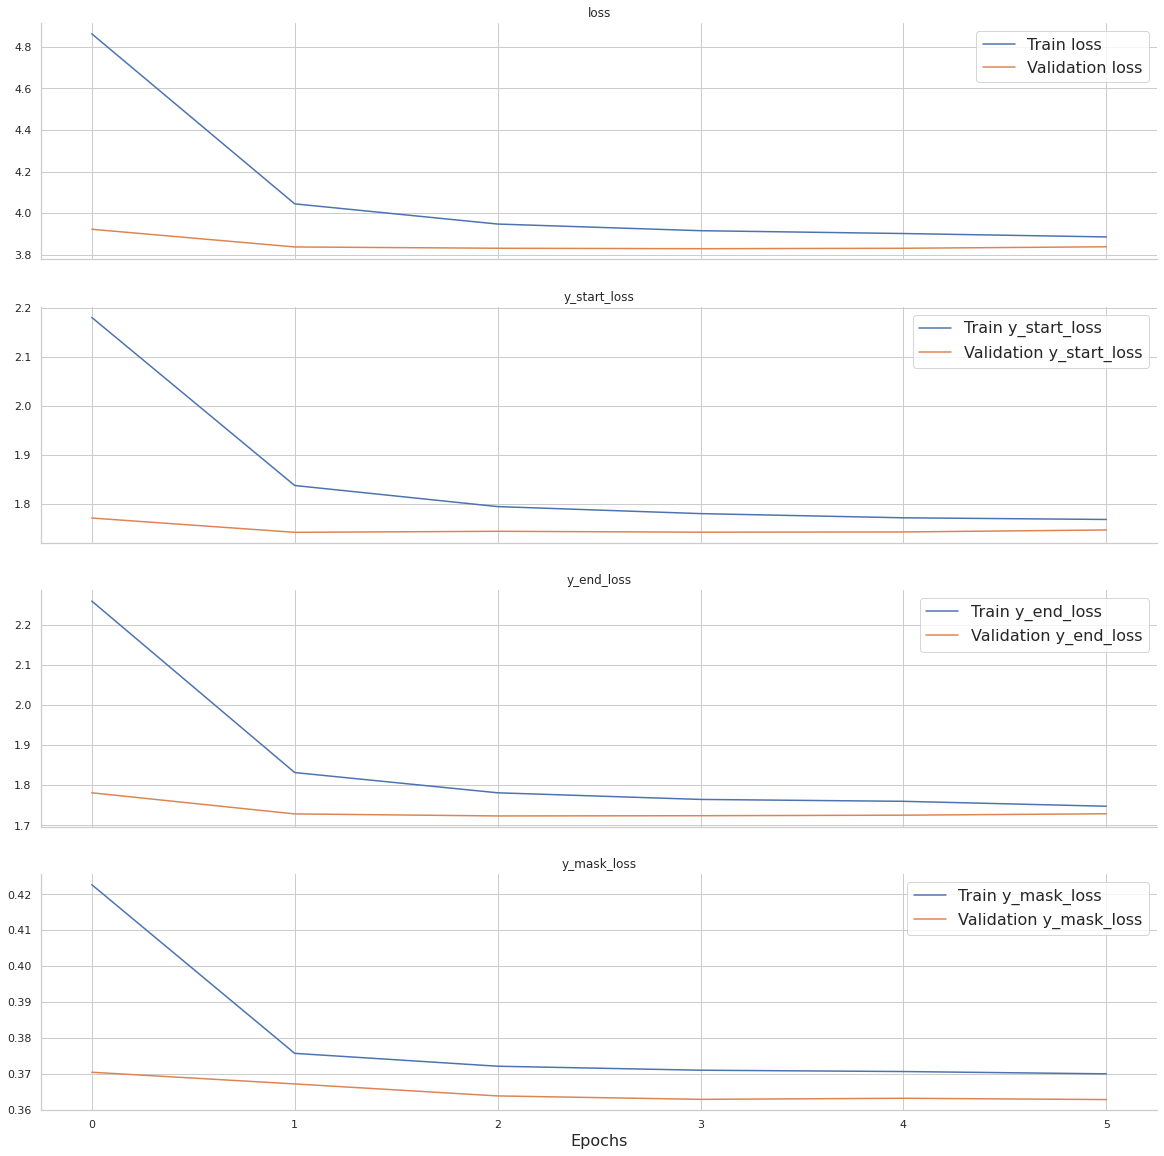

Fold: 5


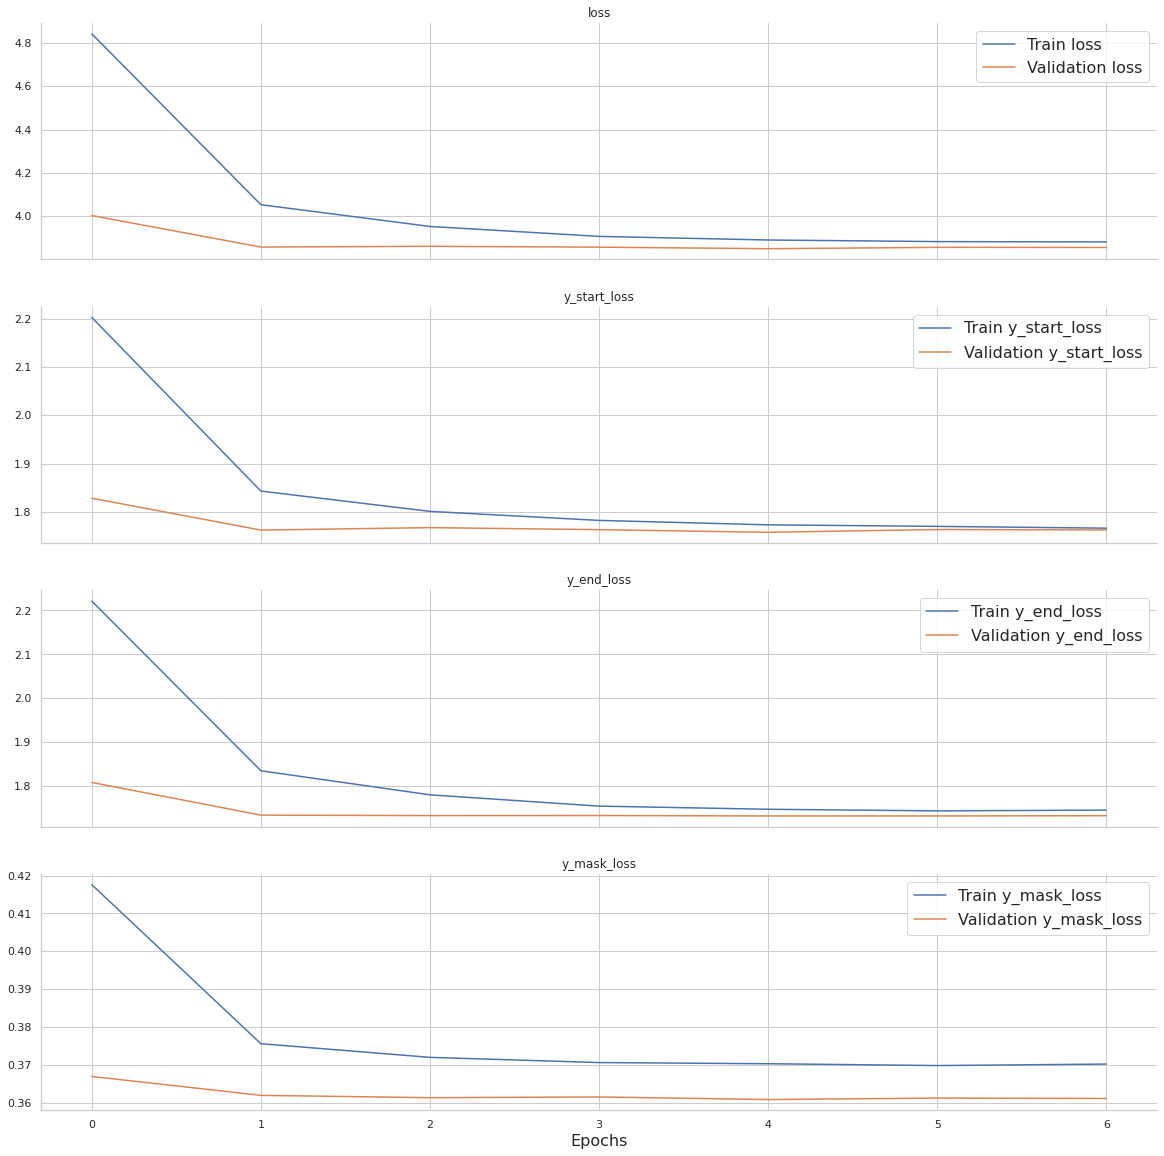

In [10]:
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [11]:
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.750229,0.717892,0.032337,0.734641,0.700664,0.750028,0.720944,0.743765,0.709493,0.750641,0.721816,0.772071,0.736544
Sentiment negative,0.633119,0.572123,0.060996,0.641506,0.572101,0.613890,0.561077,0.627310,0.579512,0.638832,0.577885,0.644056,0.570043
Sentiment neutral,0.924283,0.925250,-0.000967,0.876745,0.884643,0.949224,0.950908,0.911032,0.905744,0.922181,0.922429,0.962232,0.962525
Sentiment positive,0.622936,0.571898,0.051039,0.628485,0.570368,0.606277,0.557329,0.624964,0.564139,0.621909,0.583248,0.633047,0.584405
0 <= text tokens < 3,0.963423,0.953013,0.010409,0.964444,0.959677,0.967105,0.932203,0.961207,0.963636,0.960526,0.957627,0.963830,0.951923
3 <= text tokens < 15,0.807349,0.783965,0.023385,0.798076,0.778071,0.803302,0.788042,0.807418,0.774932,0.808974,0.785497,0.818978,0.793280
15 <= text tokens < 30,0.719059,0.682101,0.036957,0.700484,0.660824,0.720662,0.678712,0.711227,0.670104,0.719757,0.682589,0.743163,0.718279
30 <= text tokens < 45,0.674668,0.630726,0.043943,0.649825,0.593442,0.680909,0.643184,0.655155,0.633186,0.670819,0.654126,0.716633,0.629692
45 <= text tokens < 120,0.733568,0.659706,0.073863,0.725007,0.662995,0.716315,0.689426,0.752802,0.476040,0.689419,0.735728,0.784300,0.734340


# Visualize predictions

In [12]:
k_fold['jaccard_mean'] = 0

for n in range(config['N_FOLDS']):
    k_fold['jaccard_mean'] += k_fold[f'jaccard_fold_{n+1}'] / config['N_FOLDS']

display(k_fold[['text', 'selected_text', 'sentiment', 'text_tokenCnt', 
                'selected_text_tokenCnt', 'jaccard', 'jaccard_mean'] + [c for c in k_fold.columns if (c.startswith('prediction_fold'))]].head(15))

,text,selected_text,sentiment,text_tokenCnt,selected_text_tokenCnt,jaccard,jaccard_mean,prediction_fold_1,prediction_fold_2,prediction_fold_3,prediction_fold_4,prediction_fold_5
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,10,10,1.000000,1.000000,"i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going"
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,13,3,0.200000,0.900000,sooo sad,sooo sad,sad,sooo sad,sooo sad
2,my boss is bullying me...,bullying,negative,6,1,0.200000,1.000000,bullying,bullying,bullying,bullying,bullying
3,what interview! leave me alone,leave me alone,negative,6,3,0.600000,1.000000,leave me alone,leave me alone,leave me alone,leave me alone,leave me alone
4,"sons of ****, why couldn`t they put them on th...","sons of ****,",negative,17,4,0.214286,1.000000,"sons of ****,","sons of ****,","sons of ****,","sons of ****,","sons of ****,"
5,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,neutral,27,27,1.000000,0.900000,some shameless plugging for the best rangers f...,http://www.dothebouncy.com/smf - some shameles...,http://www.dothebouncy.com/smf - some shameles...,some shameless plugging for the best rangers f...,some shameless plugging for the best rangers f...
6,2am feedings for the baby are fun when he is a...,fun,positive,17,1,0.071429,1.000000,fun,fun,fun,fun,fun
7,soooo high,soooo high,neutral,3,3,1.000000,1.000000,soooo high,soooo high,soooo high,soooo high,soooo high
8,both of you,both of you,neutral,3,3,1.000000,1.000000,both of you,both of you,both of you,both of you,both of you
9,journey!? wow... u just became cooler. hehe.....,wow... u just became cooler.,positive,19,7,0.500000,0.680000,wow...,wow... u just became cooler.,wow... u just became cooler.,wow...,wow... u just became cooler.
